<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/attention_updates/tutorials/W2D5_IntroNLP/W2D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Introduction to processing time series


**Week 2, Day 3: Intro to NLP**

**By Neuromatch Academy**

__Content creators:__ Lyle Ungar, Kelson Shilling-Scrivo, Alish Dipani

__Content reviewers:__  

__Content editors:__ Kelson Shilling-Scrivo

__Production editors:__ 

Based on Content from: Anushree Hede, Pooja Consul, Ann-Katrin Reuel


**Our 2022 Sponsors, including Presenting Sponsor ?**


----
# Tutorial objectives

Before we begin with exploring how RNNs excel at modelling sequences, we will explore some of the other ways we can model sequences, encode text, and make meaningful measurements using such encodings and embeddings. 

In [ ]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/n263c/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for the videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/n263c/download).

---
## Setup

In [ ]:
# @title Install dependencies

# @markdown #### There may be *errors* and/or *warnings* reported during the installation. However, they are to be ignored.
!pip install torchtext==0.4.0 --quiet
!pip install --upgrade gensim --quiet
!pip install unidecode --quiet
!pip install fasttext --quiet
!pip install nltk --quiet
!pip install pandas --quiet
!pip install python-Levenshtein --quiet
!pip install --upgrade gensim
!pip install d2l --quiet
!pip install matplotlib==3.1.3 --quiet

!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install . 
%cd ..

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# Generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W2D3_T1','https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
fatal: destination path 'fastText' already exists and is not an empty directory.
/content/fastText
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/fastText
  DEPRECATION: A future pip 

In [ ]:
#@title Imports

import re
import os
import sys
import math
import time
import nltk
import torch
import random
import string
import unidecode
import collections
import fasttext
import requests
import zipfile
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm_notebook as tqdm

from gensim.models import Word2Vec
from nltk.corpus import brown
from sklearn.manifold import TSNE
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchtext import data, datasets
from torchtext.vocab import Vectors, FastText

from IPython.display import Image, YouTubeVideo
from d2l import torch as d2l

In [ ]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

In [ ]:
# @title  Load Dataset from `nltk`
# No critical warnings, so we suppress it
import warnings
warnings.simplefilter("ignore")

nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [ ]:
#@title Helper functions

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


---
# Section 1: Intro: What time series are there?

*Time estimate: 20 mins*

In [ ]:
# @title Video 1: Time Series and NLP
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1jg411774B", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"W4RTRXt7pO0", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 1: Time Series and NLP')

display(out)

In [ ]:
# @title Video 2: What is NLP?
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1jg411774B", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"Q-PGZyaBQVk", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 2: What is NLP')

display(out)

---
# Section 2: Embeddings

*Time estimate: 50 mins*

In [ ]:
# @title Video 3: Embeddings Rule!
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1jg411774B", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"7ijjjFpcOwI", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 3: Embeddings Rule!')

display(out)

## Section 2.1: Introduction


[Word2vec](https://rare-technologies.com/word2vec-tutorial/) is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, with each unique word in the corpus being assigned a corresponding vector in the space. 

### Creating Word Embeddings

We will create embeddings for a subset of categories in [Brown corpus](https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html).  In order to achieve this task we will use [gensim](https://radimrehurek.com/gensim/) library to create word2vec embeddings. Gensim’s word2vec expects a sequence of sentences as its input. Each sentence is a list of words.
Calling Word2Vec(sentences, iter=1) will run two passes over the sentences iterator (or, in general iter+1 passes). The first pass collects words and their frequencies to build an internal dictionary tree structure. The second and subsequent passes train the neural model. 
Word2vec accepts several parameters that affect both training speed and quality.

One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:

`model = Word2Vec(sentences, min_count=10)  # default value is 5`


A reasonable value for min_count is between 0-100, depending on the size of your dataset.

Another parameter is the size of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

`model = Word2Vec(sentences, size=200)  # default value is 100`


Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

The last of the major parameters (full list [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)) is for training parallelization, to speed up training:

`model = Word2Vec(sentences, workers=4) # default = 1 worker = no parallelization`

In [ ]:
# Categories used for the Brown corpus
category = ['editorial', 'fiction', 'government', 'mystery', 'news', 'religion',
            'reviews', 'romance', 'science_fiction']

In [ ]:
# @title Helper functions

def create_word2vec_model(category = 'news', size = 50, sg = 1, min_count = 5):
    sentences = brown.sents(categories=category) 
    model = Word2Vec(sentences, vector_size=size, sg=sg, min_count=min_count)
    return model

def model_dictionary(model):
  print(w2vmodel.wv)
  words = list(w2vmodel.wv)
  return words 

def get_embedding(word, model):
  if word in w2vmodel.wv:
    return model.wv[word]
  else:
    return None

The cell will take 30-45 seconds to run.

In [ ]:
# Create a word2vec model based on categories from Brown corpus
w2vmodel = create_word2vec_model(category)

You can get the embedding vector for a word in the dictionary.

In [ ]:
# get word list from Brown corpus
brown_wordlist = list(brown.words(categories=category))
# generate a random word
random_word = random.sample(brown_wordlist, 1)[0]
# get embedding of the random word
random_word_embedding = get_embedding(random_word, w2vmodel)
print(f'Embedding of \'{random_word}\' is {random_word_embedding}')

Embedding of 'company' is [ 2.46905759e-01 -1.38550326e-01 -3.63000232e-04  1.27632737e-01
 -2.58683920e-01  1.61984175e-01  3.00627977e-01  6.88825697e-02
  9.83046517e-02 -2.92174928e-02  1.26689747e-01  1.41526759e-01
  1.26880348e-01  2.08013672e-02 -3.32935125e-01  7.62713701e-02
  3.26526552e-01  4.31886353e-02  1.53543856e-02 -1.68283194e-01
  2.47735575e-01 -1.35603130e-01  2.09372178e-01 -1.13880806e-01
 -4.04340178e-02  2.83364207e-01 -3.22609872e-01  4.78077866e-02
 -2.81070411e-01  5.96594065e-03  1.92559749e-01 -7.89364874e-02
  5.15579641e-01 -1.30472658e-02  3.31714546e-04 -3.56695950e-02
  3.69556874e-01  2.48339370e-01  3.27481002e-01 -3.89406979e-01
  1.85233787e-01  9.57596228e-02 -4.63188291e-01 -6.33335561e-02
  4.46666270e-01  8.43590312e-03  1.65810332e-01 -1.62113458e-01
  2.11740896e-01  3.72172087e-01]


### Visualizing Word Embeddings

We can now obtain the word embeddings for any word in the dictionary using word2vec. Let's visualize these embeddings to get an inuition of what these embeddings mean. The word embeddings obtained from word2vec model are in high dimensional space. We will use PCA to pick the 2 features that capture the most variance in the embeddings in order to represent them in a 2D space.


For each word in `keys`, we pick the top 10 similar words (using cosine similarity) and plot them.  

 What should be the arrangement of similar words?
 What should be arrangement of the key clusters with respect to each other?
 

In [ ]:
keys = ['voters', 'magic', 'love', 'God', 'evidence', 'administration', 'governments']

In [ ]:
# @title Helper functions

def get_cluster_embeddings(keys):
  embedding_clusters = []
  word_clusters = []

  # find closest words and add them to cluster
  for word in keys:
      embeddings = []
      words = []
      if not word in w2vmodel.wv:
        print('The word ', word, 'is not in the dictionary')
        continue

      for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
          words.append(similar_word)
          embeddings.append(w2vmodel.wv[similar_word])
      embedding_clusters.append(embeddings)
      word_clusters.append(words)

  # get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
  return embeddings_en_2d, word_clusters

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, opacity, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=opacity, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

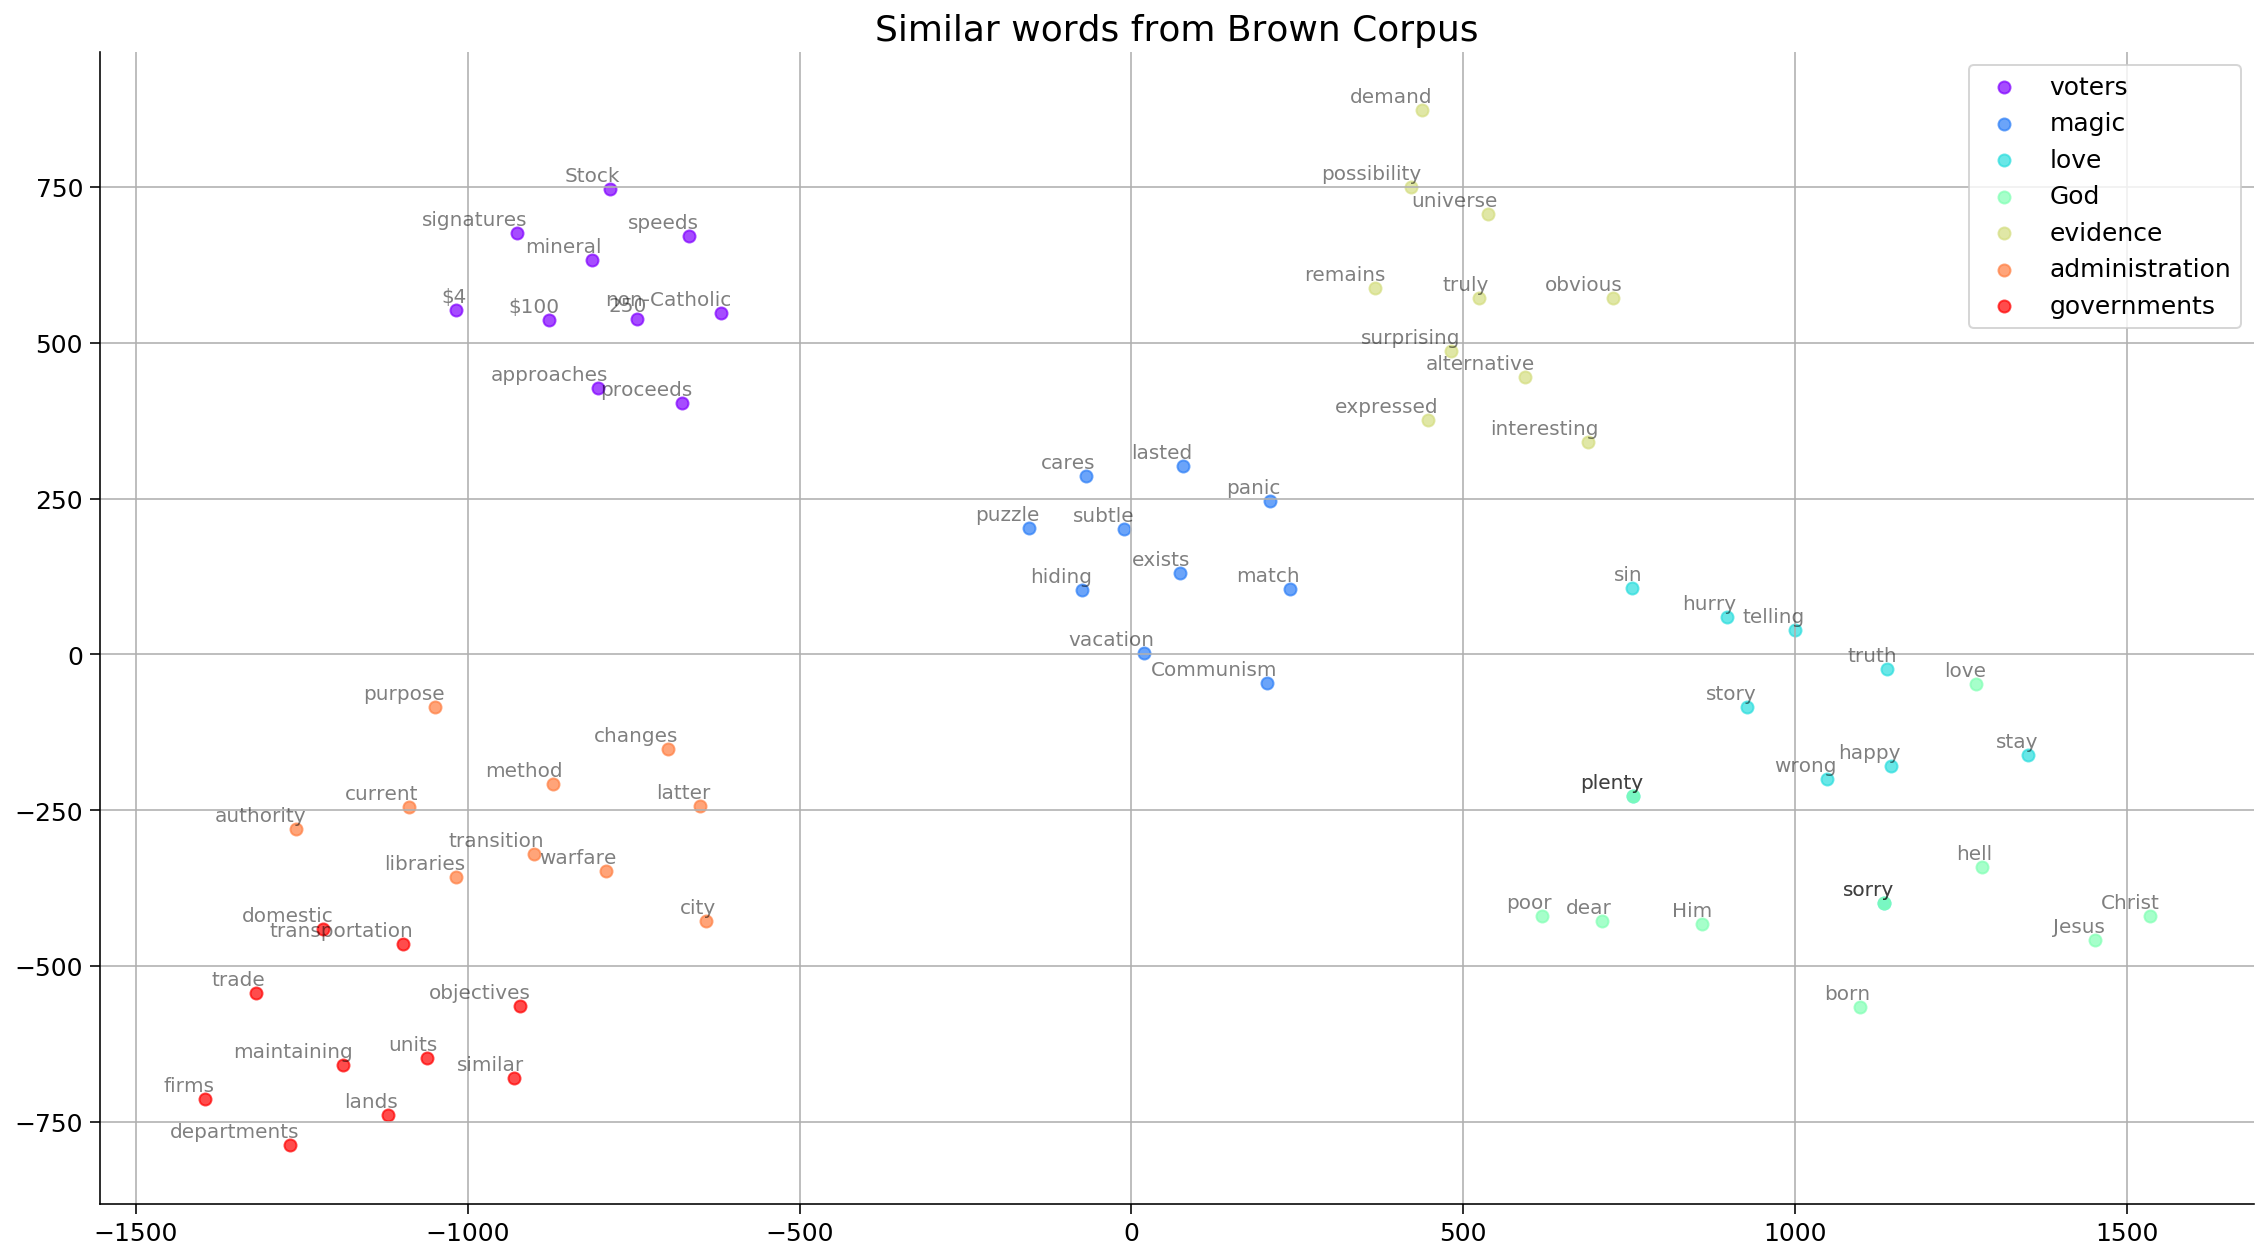

In [ ]:
# Get closest words to the keys and get clusters of these words
embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
# tSNE plot of similar words to keys
tsne_plot_similar_words(title = 'Similar words from Brown Corpus', \
                        labels = keys, \
                        embedding_clusters = embeddings_en_2d, \
                        word_clusters = word_clusters, \
                        opacity = 0.7, \
                        filename = 'similar_words.png')

#Think! 2.1
What does having higher similarity between two word embeddings mean?
 Why are cluster centers close to some keys but farther from others?

In [ ]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

## Section 2.2: Embedding exploration

In [ ]:
# @title Video 4: NLP tokenization
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1jg411774B", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"GLreyXm4rg8", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 4: NLP Tokenization')

display(out)

In [ ]:
# @title Video 5: Distributional Similarity
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1jg411774B", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"0vTuEIAnrII", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 5: Distributional Similarity')

display(out)


Words or subword units such as morphemes are the basic units that we use to express meaning  in language. The technique of mapping words to vectors of real numbers is known as word embedding. 

In this section, we will be using pretrained fastText embeddings, a context-oblivious embedding similar to word2vec. 

### Embedding Manipulation

Let's use the FastText library to manipulate the embeddings. 
First, find the embedding for the word "King"

In [ ]:
# @title Download FastText English Embeddings of dimension 100
# @markdown This will take 1-2 minutes to run

# 1d2fzekxTgDIA9LEYskPXT1sfccgAGmUF
# file_id = '11qRoFOUiGnvM04ERcN_6Qn6O_dJ2KPLk'
# destination = 'cc.en.100.bin.zip'
# download_file_from_google_drive(file_id, destination)
!wget -O cc.en.100.bin.gz https://osf.io/2frqg/download


import os
os.listdir('.')
with zipfile.ZipFile('cc.en.100.bin.gz', 'r') as zip_ref:
    zip_ref.extractall('.')


--2022-06-15 15:31:12--  https://osf.io/2frqg/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/6aws8/providers/osfstorage/605ca633fbc4980091403080?action=download&direct&version=1 [following]
--2022-06-15 15:31:12--  https://files.osf.io/v1/resources/6aws8/providers/osfstorage/605ca633fbc4980091403080?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1512369270 (1.4G) [application/octet-stream]
Saving to: ‘cc.en.100.bin.gz’

cc.en.100.bin.gz    100%[===================>]   1.41G  51.8MB/s    in 35s     

2022-06-15 15:31:49 (41.4 MB/s) - ‘cc.en.100.bin.gz’ saved [1512369270/1512369270]



In [ ]:
# Load 100 dimension FastText Vectors using FastText library
ft_en_vectors = fasttext.load_model('cc.en.100.bin')
print("Length of the embedding is: ", len(ft_en_vectors.get_word_vector('king')))
print("Embedding for the word King is: ", ft_en_vectors.get_word_vector('king'))

Cosine similarity is used for similarities between words. Similarity is a scalar between 0 and 1. Higher scalar value corresponds to higher similarity.

Now find the 10 most similar words to "King"

In [ ]:
ft_en_vectors.get_nearest_neighbors("king", 10) # Most similar by key

### Word Similarity

More on similarity between words. Let's check how similar different pairs of word are.



In [ ]:
def cosine_similarity(vec_a, vec_b):
        """Compute cosine similarity between vec_a and vec_b"""
        return np.dot(vec_a, vec_b) / \
            (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

def getSimilarity(word1, word2):
  v1 = ft_en_vectors.get_word_vector(word1)
  v2 = ft_en_vectors.get_word_vector(word2)
  return cosine_similarity(v1, v2)

print("Similarity between the words King and Queen: ", getSimilarity("king", "queen"))
print("Similarity between the words King and Knight: ", getSimilarity("king", "knight"))
print("Similarity between the words King and Rock: ", getSimilarity("king", "rock"))
print("Similarity between the words King and Twenty: ", getSimilarity("king", "twenty"))
print()
print("Similarity between the words Dog and Cat: ", getSimilarity("dog", "cat"))
print("Similarity between the words Ascending and Descending: ", getSimilarity("ascending", "descending"))
print("Similarity between the words Victory and Defeat: ", getSimilarity("victory", "defeat"))
print("Similarity between the words Less and More: ", getSimilarity("less", "more"))
print("Similarity between the words True and False: ", getSimilarity("true", "false"))

In [ ]:
# @title Interactive Demo
# @markdown Check similarity between words
word1 = 'King' #@param \ {type:"string"}
word2 = 'Frog' #@param \ {type:"string"}
word_similarity = getSimilarity(word1, word2)
print(f'Similarity between {word1} and {word2}: {word_similarity}')

Using embeddings, we can find the words that appear in similar contexts. But, what happens if the word has several different meanings? 

### Homonym Similarity

Homonyms are words which have same spelling or pronunciation but different meanings depending on the context. Let's explore how these words are embedded and their similarity in different contexts.

In [ ]:
#######################     Words with multiple meanings     ##########################
print("Similarity between the words Cricket and Insect: ", getSimilarity("cricket", "insect"))
print("Similarity between the words Cricket and Sport: ", getSimilarity("cricket", "sport"))

In [ ]:
# @title Interactive Demo
# @markdown Explore homonyms \\
# @markdown examples - minute (time/small), pie (graph/food)
word = 'minute' #@param \ {type:"string"}
context_word_1 = 'time' #@param \ {type:"string"}
context_word_2 = 'small' #@param \ {type:"string"}
word_similarity_1 = getSimilarity(word, context_word_1)
word_similarity_2 = getSimilarity(word, context_word_2)
print(f'Similarity between {word} and {context_word_1}: {word_similarity_1}')
print(f'Similarity between {word} and {context_word_2}: {word_similarity_2}')

### Word Analogies

Embeddings can be used to find word analogies.
Let's try it:
1.   Man : Woman  ::  King : _____
2.  Germany: Berlin :: France : _____
3.  Leaf : Tree  ::  Petal : _____





In [ ]:
## Use get_analogies() funnction. 
# The words have to be in the order Positive, negative,  Positve

# Man : Woman  ::  King : _____
# Positive=(woman, king), Negative=(man)
print(ft_en_vectors.get_analogies("woman", "man", "king",1)) 

# Germany: Berlin :: France : ______
# Positive=(berlin, frannce), Negative=(germany)
print(ft_en_vectors.get_analogies("berlin", "germany", "france",1))

# Leaf : Tree  ::  Petal : _____
# Positive=(tree, petal), Negative=(leaf)
print(ft_en_vectors.get_analogies("tree", "leaf", "petal",1))

But, does it always work?


1.   Poverty : Wealth  :: Sickness : _____
2.   train : board :: horse : _____

In [ ]:
# Poverty : Wealth  :: Sickness : _____
print(ft_en_vectors.get_analogies("wealth", "poverty", "sickness",1))

# train : board :: horse : _____
print(ft_en_vectors.get_analogies("board", "train", "horse",1))

---
## Section 2.3: Neural Net with word embeddings

In [ ]:
#@title Sentence Embeddings
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="skFimcn320U", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

Training context-oblivious word embeddings is relatively cheap, but most people still use pre-trained word embeddings. After we cover context sensitive word embeddings we'll see how to "fine tune" embeddings (adjust them to the task at hand).

Let's use the pretrained FastText embeddings to train a neural network on the IMDB dataset. 

The data consists of reviews and sentiments attached to it. It is a binary classification task.

###  Coding Exercise 1: Simple feed forward net

Define a vanilla neural network with linear layers. Then average the word embeddings to get an embedding for the entire review.
The neural net will have one hidden layer of size 128.

In [ ]:
class NeuralNet(nn.Module):
  """ A vanilla neural network. """
  def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
    """
    Constructs a vanilla Neural Network Instance.

    Args:
      batch_size: Integer
        Specifies probability of dropout hyperparameter
      output_size: Integer
        Specifies the size of output vector
      hidden_size: Integer
        Specifies the size of hidden layer
      vocab_size: Integer
        Specifies the size of the vocabulary
        i.e. the number of tokens in the vocabulary
      embedding_length: Integer
        Specifies the size of the embedding vector
      word_embeddings
        Specifies the weights to create embeddings from
        voabulary.

    Returns:
      Nothing
    """
    super(NeuralNet, self).__init__()

    self.batch_size = batch_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, inputs):
    """
    Compute the final labels by taking tokens as input.

    Args:
      inputs: Tensor
        Tensor of tokens in the text

    Returns:
      out: Tensor
        Final prediction Tensor
    """
    input = self.word_embeddings(inputs) #convert text to embeddings
    #################################################
    # Implement a vanilla neural network
    raise NotImplementedError("Neural Net `forward`")
    #################################################
    
    #Average the word embedddings in a sentence
    #Use torch.nn.functional.avg_pool2d to compute the averages
    pooled = F.avg_pool2d(..., (input.shape[1], 1)).squeeze(1)

    # Pass the embeddings through the neural net
    # Use ReLU as the non-linearity
    x = ...
    x = ...
    x = ...
    output = F.log_softmax(x, dim=1)    
    return output

# add event to airtable
atform.add_event('Coding Exercise 1: Neural Net for text classification')

In [ ]:
# to_remove solution
class NeuralNet(nn.Module):
  """ A vanilla neural network. """
  def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
    """
    Constructs a vanilla Neural Network Instance.

    Args:
      batch_size: Integer
        Specifies probability of dropout hyperparameter
      output_size: Integer
        Specifies the size of output vector
      hidden_size: Integer
        Specifies the size of hidden layer
      vocab_size: Integer
        Specifies the size of the vocabulary
        i.e. the number of tokens in the vocabulary
      embedding_length: Integer
        Specifies the size of the embedding vector
      word_embeddings
        Specifies the weights to create embeddings from
        voabulary.

    Returns:
      Nothing
    """
    super(NeuralNet, self).__init__()

    self.batch_size = batch_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, inputs):
    """
    Compute the final labels by taking tokens as input.

    Args:
      inputs: Tensor
        Tensor of tokens in the text

    Returns:
      out: Tensor
        Final prediction Tensor
    """
    input = self.word_embeddings(inputs) #convert text to embeddings
    #Average the word embedddings in a sentence
    #Use torch.nn.functional.avg_pool2d to compute the averages
    pooled = F.avg_pool2d(input, (input.shape[1], 1)).squeeze(1)

    #Pass the embeddings through the neural net
    x = self.fc1(pooled)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)    
    return output

# add event to airtable
atform.add_event('Coding Exercise 1: Neural Net for text classification')

In [ ]:
#@title Helper functions
# @markdown Training and Testing Functions \\
# @markdown Dataset Creation Functions \\ 
# @markdown Plotting Functions

# Plotting
def plot_train_val(x, train, val, train_label, val_label, title):
  plt.plot(x, train, label=train_label)
  plt.plot(x, val, label=val_label)
  plt.legend()
  plt.xlabel('epoch')
  plt.title(title)
  plt.show()

# Dataset
def tokenize(sentences):
  #Tokenize the sentence
  #from nltk.tokenize library use word_tokenize
  token = word_tokenize(sentences)
  
  return token

def load_dataset(emb_vectors, seed, sentence_length = 50):
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

    TEXT.build_vocab(train_data, vectors=emb_vectors)
    LABEL.build_vocab(train_data)

    train_data, valid_data = train_data.split(split_ratio=0.7, random_state = random.seed(seed))
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=32, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, train_iter, valid_iter, test_iter

# Training
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in range(epochs):
      #train
      model.train()
      running_loss = 0.
      correct, total = 0, 0 
      steps = 0

      for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        # add micro for coding training loop
        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        steps += 1
        running_loss += loss.item()

        # get accuracy 
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
      train_loss.append(running_loss/len(train_iter))
      train_acc.append(correct/total)

      print(f'Epoch: {epoch + 1},  Training Loss: {running_loss/len(train_iter):.4f}, Training Accuracy: {100*correct/total: .2f}%')

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0 

      with torch.no_grad():
        for idx, batch in enumerate(valid_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(text)
    
            loss = criterion(output, target)
            running_loss += loss.item()

            # get accuracy 
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(valid_iter))
      validation_acc.append(correct/total)

      print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, Validation Accuracy: {100*correct/total: .2f}% \n')
  
    return train_loss, train_acc, validation_loss, validation_acc

#Testing
def test(model,  device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        outputs = model(text)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

In [ ]:
# @title Download embeddings and load the dataset
# @markdown This will load 300 dim FastText embeddings. \\
# @markdown It will take around 3-4 minutes.
embedding_fasttext = FastText('simple')
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(embedding_fasttext, SEED)

In [ ]:
learning_rate = 0.0003
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300
epochs = 15
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)

nn_model = NeuralNet(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
nn_model.to(DEVICE)
nn_start_time = time.time()
nn_train_loss, nn_train_acc, nn_validation_loss, nn_validation_acc = train(nn_model, DEVICE, train_iter, valid_iter, epochs, learning_rate)
print()
print("--- Time taken to train = %s seconds ---" % (time.time() - nn_start_time))
test_accuracy = test(nn_model, DEVICE, test_iter)
print()
print('Test Accuracy: ',  test_accuracy, '%')

Epoch: 1,  Training Loss: 0.6653, Training Accuracy:  60.33%
Validation Loss: 0.6441, Validation Accuracy:  63.69% 

Epoch: 2,  Training Loss: 0.6243, Training Accuracy:  66.15%
Validation Loss: 0.6156, Validation Accuracy:  66.88% 

Epoch: 3,  Training Loss: 0.5983, Training Accuracy:  68.33%
Validation Loss: 0.6013, Validation Accuracy:  67.99% 

Epoch: 4,  Training Loss: 0.5859, Training Accuracy:  69.23%
Validation Loss: 0.5948, Validation Accuracy:  68.55% 

Epoch: 5,  Training Loss: 0.5798, Training Accuracy:  70.00%
Validation Loss: 0.5919, Validation Accuracy:  68.40% 

Epoch: 6,  Training Loss: 0.5753, Training Accuracy:  69.87%
Validation Loss: 0.5896, Validation Accuracy:  68.97% 

Epoch: 7,  Training Loss: 0.5722, Training Accuracy:  70.35%
Validation Loss: 0.5880, Validation Accuracy:  68.57% 

Epoch: 8,  Training Loss: 0.5702, Training Accuracy:  70.49%
Validation Loss: 0.5964, Validation Accuracy:  67.61% 

Epoch: 9,  Training Loss: 0.5683, Training Accuracy:  70.49%
Val

In [ ]:
with plt.xkcd():
    plot_train_val(np.arange(0,epochs), nn_train_acc, nn_validation_acc,
                   'training_accuracy', 'validation_accuracy', 'Neural Net on IMDB text classification')

with plt.xkcd():
    plot_train_val(np.arange(0,epochs), nn_train_loss, nn_validation_loss,
                   'training_loss', 'validation_loss', 'Neural Net on IMDB text classification')

NameError: ignored

---
# Summary

In this tutorial we introduced how to process time series by taking language as an example. To process time series, they can be converted into embeddings.  
  
For text, we can first tokenize the words and then create either context-oblivious embeddings or context-dependent embeddings.  
  
Finally, we saw how these words embeddings can be processed for applications such as text classification.

In [ ]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/AirtableSubmissionButton.png?raw=1"
 alt="button link to Airtable" style="width:410px"></a>
   </div>""" )

# Bonus 1 : Multilingual Embeddings

Traditionally, word embeddings have been lnaguage-specific, with embeddings for each language trained separately and existing in entirely different vector spaces. But, what if we wanted to compare words in one language to another language? Say, we want to create a text classifier with a corpus consisting of English and Spanish words. 

We use the multilingual word embeddings provided in fastText. More information can be found [here](https://engineering.fb.com/2018/01/24/ml-applications/under-the-hood-multilingual-embeddings/).

## Training multilingual embeddings
We first train separate embeddings for each language using fastText and a combination of data from Facebook and Wikipedia. Then, we find a dictionary of common words between the two languages. The dictionaries are automatically induced from parallel data - datasets that consist of a pair of sentences in two different languages that have the same meaning. 

Then, we find a matrix that projects the embeddings into a common space between the given languages. The matrix is designed to minimize the distance between a word $x_i$ and its projection $y_i$. If our dictionary consists of pairs $(x_i, y_i)$, our projector $M$ would be: 

$$M = \text{argmin}_W\sum_i ||x_i - Wy_ii||^2$$

Also, the projector matrix $W$ is constrained to e orthogonal so that original distances between word embedding vectors are preserved. Multilingual models are trained by using our multilingual word embeddings as the base representations in DeepText and “freezing” them, or leaving them unchanged during the training process. 


After going through this, try to replicate the above exercises but in different languages! 


In [ ]:
# @title Download FastText French Embeddings of dimension 100
# @markdown **P.S. - This cell might take 10-15 minutes to run**

!wget -O cc.fr.100.bin.gz https://osf.io/6tqvp/download

with zipfile.ZipFile('cc.fr.100.bin.gz', 'r') as zip_ref:
    zip_ref.extractall('.')

--2022-06-15 15:35:44--  https://osf.io/6tqvp/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/6aws8/providers/osfstorage/605ca6421a175b009644f2c1?action=download&direct&version=1 [following]
--2022-06-15 15:35:44--  https://files.osf.io/v1/resources/6aws8/providers/osfstorage/605ca6421a175b009644f2c1?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1509233727 (1.4G) [application/octet-stream]
Saving to: ‘cc.fr.100.bin.gz’

cc.fr.100.bin.gz    100%[===================>]   1.41G  2.93MB/s    in 8m 52s  

2022-06-15 15:44:40 (2.70 MB/s) - ‘cc.fr.100.bin.gz’ saved [1509233727/1509233727]



In [ ]:
# Load 100 dimension FastText Vectors using FastText library
french = fasttext.load_model('cc.fr.100.bin')

First, we take a look at the cosine similarity between different languages without projecting them into the same vector space. As you can see, the same words seem to be close to $0$ cosine similarity in different languages - so neither similar nor dissimilar. 

In [ ]:
hello = ft_en_vectors.get_word_vector('hello')
hi = ft_en_vectors.get_word_vector('hi')
bonjour = french.get_word_vector('bonjour')

print("Cosine Similarity between HI and HELLO: {}".format(cosine_similarity(hello, hi)))
print("Cosine Similarity between BONJOUR and HELLO: {}".format(cosine_similarity(hello, bonjour)))


Cosine Similarity between HI and HELLO: 0.7028388977050781
Cosine Similarity between BONJOUR and HELLO: 0.20523205399513245


In [ ]:
cat = ft_en_vectors.get_word_vector('cat')
chatte = french.get_word_vector('chatte')
chat = french.get_word_vector('chat')

print("Cosine Similarity between cat and chatte: {}".format(cosine_similarity(cat, chatte)))
print("Cosine Similarity between cat and chat: {}".format(cosine_similarity(cat, chat)))
print("Cosine Similarity between chatte and chat: {}".format(cosine_similarity(chatte, chat)))


Cosine Similarity between cat and chatte: -0.013087842613458633
Cosine Similarity between cat and chat: -0.02490561455488205
Cosine Similarity between chatte and chat: 0.6003134250640869


First, let's define a list of words that are in common between English and French. We'll be using this to make our training matrices. 

In [ ]:
en_words = set(ft_en_vectors.words)
fr_words = set(french.words)
overlap = list(en_words & fr_words)
bilingual_dictionary = [(entry, entry) for entry in overlap]

We define a few functions to make our lives a bit easier: `make_training_matrices` takes in the source words, target language words, and the set of common words. It then creates a matrix of all the word embeddings of all common words between the languages (in each language). These are our training matrices. 

The function `learn_transformation` then takes in these matrices, normalizes them, and then performs SVD, which aligns the source language to the target and returns a transformation matrix. 

In [ ]:
def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
    source_matrix = []
    target_matrix = []

    for (source, target) in tqdm(bilingual_dictionary):
        #if source in source_dictionary.words and target in target_dictionary.words:
        source_matrix.append(source_dictionary.get_word_vector(source))
        target_matrix.append(target_dictionary.get_word_vector(target))

    # return training matrices
    return np.array(source_matrix), np.array(target_matrix)

# from https://stackoverflow.com/questions/21030391/how-to-normalize-array-numpy
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

Now, we just have to put it all together! 

In [ ]:
source_training_matrix, target_training_matrix = make_training_matrices(ft_en_vectors, french, bilingual_dictionary)

  0%|          | 0/612423 [00:00<?, ?it/s]

In [ ]:
transform = learn_transformation(source_training_matrix, target_training_matrix)

Let's run the same examples as above, but this time, whenever we use French words, matrix multiply the embedding by the transpose of the transform matrix. That works a lot better! 

In [ ]:
hello = ft_en_vectors.get_word_vector('hello')
hi = ft_en_vectors.get_word_vector('hi')
bonjour = np.matmul(french.get_word_vector('bonjour'), transform.T)

print("Cosine Similarity between HI and HELLO: {}".format(cosine_similarity(hello, hi)))
print("Cosine Similarity between BONJOUR and HELLO: {}".format(cosine_similarity(hello, bonjour)))


In [ ]:
cat = ft_en_vectors.get_word_vector('cat')
chatte = np.matmul(french.get_word_vector('chatte'), transform.T)
chat = np.matmul(french.get_word_vector('chat'), transform.T)

print("Cosine Similarity between cat and chatte: {}".format(cosine_similarity(cat, chatte)))
print("Cosine Similarity between cat and chat: {}".format(cosine_similarity(cat, chat)))
print("Cosine Similarity between chatte and chat: {}".format(cosine_similarity(chatte, chat)))


Now, try a couple of your own examples. Try some of the examples you looked at in $2.1$, but with English and French. Does it work as expected? 

In [ ]:
# USE THIS SPACE TO TRY YOUR OWN EXAMPLES

In [ ]:
#@markdown Clean Up of Previous Files (MUST RUN)
!rm cc.en.100.bin.zip
!rm cc.fr.100.bin.gz
!rm cc.en.100.bin
!rm cc.fr.100.bin

rm: cannot remove 'cc.en.100.bin.zip': No such file or directory
